In [1]:
# cargo las librerias que necesito
if(!require("data.table")) install.packages("data.table")
require("data.table")

if(!require("parallel")) install.packages("parallel")
require("parallel")

if(!require("R.utils")) install.packages("R.utils")
require("R.utils")

if( !require("primes") ) install.packages("primes")
require("primes")

if( !require("utils") ) install.packages("utils")
require("utils")

if( !require("rlist") ) install.packages("rlist")
require("rlist")

if( !require("yaml")) install.packages("yaml")
require("yaml")

if( !require("lightgbm") ) install.packages("lightgbm")
require("lightgbm")

if( !require("DiceKriging") ) install.packages("DiceKriging")
require("DiceKriging")

if( !require("mlrMBO") ) install.packages("mlrMBO")
require("mlrMBO")

if( !require("ggplot2") ) install.packages("ggplot2")
require("ggplot2")

Cargando paquete requerido: data.table

Cargando paquete requerido: parallel

Cargando paquete requerido: R.utils

Cargando paquete requerido: R.oo

Cargando paquete requerido: R.methodsS3

R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.27.1 (2025-05-02 21:00:05 UTC) successfully loaded. See ?R.oo for help.


Adjuntando el paquete: 'R.oo'


The following object is masked from 'package:R.methodsS3':

    throw


The following objects are masked from 'package:methods':

    getClasses, getMethods


The following objects are masked from 'package:base':

    attach, detach, load, save


R.utils v2.13.0 (2025-02-24 21:20:02 UTC) successfully loaded. See ?R.utils for help.


Adjuntando el paquete: 'R.utils'


The following object is masked from 'package:utils':

    timestamp


The following objects are masked from 'package:base':

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings


Cargando paquete requerido: prime

In [2]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2088449,111.6,4054784,216.6,2937288,156.9
Vcells,3612812,27.6,8388608,64.0,5742622,43.9


# Clase Ternaria

In [ ]:
# Genero clase ternaria
# leo el dataset
setwd("~/buckets/b1/datasets")
dataset <- fread("./competencia_01_crudo.csv" )

# calculo el periodo0 consecutivo
dsimple <- dataset[, list(
    "pos" = .I,
    numero_de_cliente,
    periodo0 = as.integer(foto_mes/100)*12 +  foto_mes%%100 ) ]


# ordeno
setorder( dsimple, numero_de_cliente, periodo0 )

# calculo topes
periodo_ultimo <- dsimple[, max(periodo0) ]
periodo_anteultimo <- periodo_ultimo - 1


# calculo los leads de orden 1 y 2
dsimple[, c("periodo1", "periodo2") :=
    shift(periodo0, n=1:2, fill=NA, type="lead"),  numero_de_cliente ]

# assign most common class values = "CONTINUA"
dsimple[ periodo0 < periodo_anteultimo, clase_ternaria := "CONTINUA" ]

# calculo BAJA+1
dsimple[ periodo0 < periodo_ultimo &
    ( is.na(periodo1) | periodo0 + 1 < periodo1 ),
    clase_ternaria := "BAJA+1" ]

# calculo BAJA+2
dsimple[ periodo0 < periodo_anteultimo & (periodo0+1 == periodo1 )
    & ( is.na(periodo2) | periodo0 + 2 < periodo2 ),
    clase_ternaria := "BAJA+2" ]


# pego el resultado en el dataset original y grabo
setorder( dsimple, pos )
dataset[, clase_ternaria := dsimple$clase_ternaria ]

fwrite( dataset,
    file =  "./competencia_01.csv.gz",
    sep = ","
)

# Parámetros

In [ ]:
# Parámetros
PARAM <- list()
PARAM$experimento <- "expC01_Prueba03"
PARAM$semillas_primigenias <- c(200003, 300007, 400009, 500009, 600011)

# training y future
PARAM$train <- c(202101, 202102)
PARAM$train_final <- c(202101, 202102)
PARAM$future <- c(202104)
PARAM$train_final_kaggle <- c(202101, 202102, 202103, 202104)
PARAM$entrega_kaggle <- c(202106)
PARAM$semilla_kaggle <- 314159 #Semilla para el modelo final que va a Kaggle, primeros números de pi que sean primos.
PARAM$cortes <- seq(0, 20000, by= 100)

# un undersampling de 0.1  toma solo el 10% de los CONTINUA
# undersampling de 1.0  implica tomar TODOS los datos

PARAM$trainingstrategy$undersampling <- 0.5

# Parametros LightGBM

PARAM$hyperparametertuning$xval_folds <- 5

# parametros fijos del LightGBM que se pisaran con la parte variable de la BO
PARAM$lgbm$param_fijos <-  list(
  boosting= "gbdt", # puede ir dart, ni pruebe random_forest
  objective= "binary", #default regression
  metric= "auc", # default "" 
  first_metric_only= FALSE, # default FALSE
  boost_from_average= TRUE, # default TRUE
  feature_pre_filter= FALSE, # default TRUE
  force_row_wise= TRUE, # para reducir warnings
  verbosity= -100, # default 1

  seed= 1, # Relacionado con data_random_seed, feature_fraction_seed, entre otros 

  max_depth= -1L, # -1 significa no limitar,  por ahora lo dejo fijo
  min_gain_to_split= 0, # min_gain_to_split >= 0
  min_sum_hessian_in_leaf= 0.001, #  min_sum_hessian_in_leaf >= 0.0
  lambda_l1= 0.0, # lambda_l1 >= 0.0
  lambda_l2= 0.0, # lambda_l2 >= 0.0
  max_bin= 31L, # lo debo dejar fijo, no participa de la BO

  bagging_fraction= 1.0, # 0.0 < bagging_fraction <= 1.0
  pos_bagging_fraction= 1.0, # 0.0 < pos_bagging_fraction <= 1.0
  neg_bagging_fraction= 1.0, # 0.0 < neg_bagging_fraction <= 1.0
  is_unbalance= FALSE, # Default FALSE
  scale_pos_weight= 1.0, # scale_pos_weight > 0.0

  drop_rate= 0.1, # 0.0 < neg_bagging_fraction <= 1.0
  max_drop= 50, # <=0 means no limit
  skip_drop= 0.5, # 0.0 <= skip_drop <= 1.0

  extra_trees= FALSE, # default FALSE

  num_iterations= 1200, # default 100
  learning_rate= 0.02, # default 0.1
  feature_fraction= 0.5, # default 1
  num_leaves= 750, # default 31
  min_data_in_leaf= 5000 # default 20
)

# Aqui se cargan los bordes de los hiperparametros de la BO
PARAM$hypeparametertuning$hs <- makeParamSet(
  makeIntegerParam("num_iterations", lower= 50L, upper= 3000L),
  makeNumericParam("learning_rate", lower= 0.005, upper= 0.1),
  makeNumericParam("feature_fraction", lower= 0.1, upper= 1.0),
  makeIntegerParam("num_leaves", lower= 1L, upper= 2048L),
  makeIntegerParam("min_data_in_leaf", lower= 1L, upper= 8000L)
)

PARAM$hyperparametertuning$iteraciones <- 100 # iteraciones bayesianas

# Funciones

In [3]:
# particionar agrega una columna llamada fold a un dataset
#   que consiste en una particion estratificada segun agrupa
# particionar( data=dataset, division=c(70,30),
#  agrupa=clase_ternaria, seed=semilla)   crea una particion 70, 30

particionar <- function(data, division, agrupa= "", campo= "fold", start= 1, seed= NA) {
  if (!is.na(seed)) set.seed(seed, "L'Ecuyer-CMRG")

  bloque <- unlist(mapply(
    function(x, y) {rep(y, x)},division, seq(from= start, length.out= length(division))))

  data[, (campo) := sample(rep(bloque,ceiling(.N / length(bloque))))[1:.N],by= agrupa]
}

In [4]:
# iniciliazo el dataset de realidad, para medir ganancia
realidad_inicializar <- function( pfuture, pparam) {

  # datos para verificar la ganancia
  drealidad <- pfuture[, list(numero_de_cliente, foto_mes, clase_ternaria)]

  particionar(drealidad,
    division= c(3, 7),
    agrupa= "clase_ternaria",
    seed= PARAM$semilla_kaggle
  )

  return( drealidad )
}

In [5]:
# evaluo ganancia en los datos de la realidad

realidad_evaluar <- function( prealidad, pprediccion) {

  prealidad[ pprediccion,
    on= c("numero_de_cliente", "foto_mes"),
    predicted:= i.Predicted
  ]

  tbl <- prealidad[, list("qty"=.N), list(fold, predicted, clase_ternaria)]

  res <- list()
  res$public  <- tbl[fold==1 & predicted==1L, sum(qty*ifelse(clase_ternaria=="BAJA+2", 780000, -20000))]/0.3
  res$private <- tbl[fold==2 & predicted==1L, sum(qty*ifelse(clase_ternaria=="BAJA+2", 780000, -20000))]/0.7
  res$total <- tbl[predicted==1L, sum(qty*ifelse(clase_ternaria=="BAJA+2", 780000, -20000))]

  prealidad[, predicted:=NULL]
  return( res )
}

# Configuración del Dataset

In [6]:
# lectura del dataset
dataset <- fread("./competencia_01.csv.gz", stringsAsFactors= TRUE)

In [ ]:
# Genero los lags de orden 1
# Columnas que quieres excluir
cols_a_excluir <- c("numero_de_cliente", "foto_mes", "clase_ternaria")

# Nombres de las columnas a las que se les aplicará el lag
cols_con_lag <- setdiff(names(dataset), cols_a_excluir)

# Nombres para las nuevas columnas de lags
nombres_nuevas_cols_lag <- paste0(cols_con_lag, "_lag1")

# Calcular los lags de orden 1
dataset[, (nombres_nuevas_cols_lag) := shift(.SD, 1, NA, "lag"), by = numero_de_cliente, .SDcols = cols_con_lag]

# Nombres para las nuevas columnas de delta lags
nombres_nuevas_cols_delta <- paste0(cols_con_lag, "_delta1")

# Calcular los delta lags (valor actual - valor del lag)
dataset[, (nombres_nuevas_cols_delta) := .SD - mget(nombres_nuevas_cols_lag), .SDcols = cols_con_lag]

# Entrenamiento del ensemble

In [ ]:
# En el argumento x llegan los parmaetros de la bayesiana
#  devuelve la AUC en cross validation del modelo entrenado

EstimarGanancia_AUC_lightgbm <- function(x) {

  # x pisa (o agrega) a param_fijos
  param_completo <- modifyList(PARAM$lgbm$param_fijos, x)

  # entreno LightGBM
  modelocv <- lgb.cv(
    data= dtrain,
    nfold= PARAM$hyperparametertuning$xval_folds,
    stratified= TRUE,
    param= param_completo
  )

  # obtengo la ganancia
  AUC <- modelocv$best_score

  # hago espacio en la memoria
  rm(modelocv)
  gc(full= TRUE, verbose= FALSE)

  message(format(Sys.time(), "%a %b %d %X %Y"), " AUC ", AUC)

  return(AUC)
}

In [ ]:
setwd("~/buckets/b1/exp/")
dir.create(PARAM$experimento, showWarnings=FALSE)
setwd(paste0("~/buckets/b1/exp/",PARAM$experimento))

# Lista para almacenar la tabla de predicción de cada modelo
predicciones_ensemble <- list()

# Recorro cada semilla
for (semilla_actual in PARAM$semillas_primigenias) {
  
  cat("\n")
  cat("---------------------------------------------------\n")
  cat("Procesando semilla:", semilla_actual, "\n")
  cat("---------------------------------------------------\n")

  # Asigno la semilla actual al parámetro que usa el resto del script
  PARAM$semilla_primigenia <- semilla_actual
  
  #--- Preparación de datos (undersampling) con la semilla actual ---
  dataset_train <- dataset[foto_mes %in% PARAM$train]

  dataset_train[,
    clase01 := ifelse(clase_ternaria %in% c("BAJA+2","BAJA+1"), 1L, 0L)
  ]
  
  set.seed(PARAM$semilla_primigenia, kind = "L'Ecuyer-CMRG")
  dataset_train[, azar := runif(nrow(dataset_train))]
  dataset_train[, training := 0L]
  dataset_train[foto_mes %in% PARAM$train & (azar <= PARAM$trainingstrategy$undersampling | clase_ternaria %in% c("BAJA+1", "BAJA+2")),
                training := 1L]
  
  campos_buenos <- setdiff(colnames(dataset_train), c("clase_ternaria", "clase01", "azar", "training"))
  
  dtrain <- lgb.Dataset(data= data.matrix(dataset_train[training == 1L, campos_buenos, with= FALSE]),
                        label= dataset_train[training == 1L, clase01], free_raw_data= FALSE)
  
  #--- Optimización Bayesiana ---
  dir.create("Archivos Bayesiana", showWarnings=FALSE)
  kbayesiana <- paste0("./Archivos Bayesiana/bayesiana_", semilla_actual, ".RDATA")

  funcion_optimizar <- EstimarGanancia_AUC_lightgbm
  configureMlr(show.learner.output= FALSE)
  obj.fun <- makeSingleObjectiveFunction(fn= funcion_optimizar, minimize= FALSE, noisy= TRUE,
                                         par.set= PARAM$hypeparametertuning$hs, has.simple.signature= FALSE)
  ctrl <- makeMBOControl(save.on.disk.at.time= 600, save.file.path= kbayesiana)
  ctrl <- setMBOControlTermination(ctrl, iters= PARAM$hyperparametertuning$iteraciones)
  ctrl <- setMBOControlInfill(ctrl, crit= makeMBOInfillCritEI())
  surr.km <- makeLearner("regr.km", predict.type= "se", covtype= "matern3_2", control= list(trace= TRUE))

  if (!file.exists(kbayesiana)) {
    bayesiana_salida <- mbo(obj.fun, learner= surr.km, control= ctrl)
  } else {
    bayesiana_salida <- mboContinue(kbayesiana)
  }
  
  tb_bayesiana <- as.data.table(bayesiana_salida$opt.path)
  setorder(tb_bayesiana, -y)
  
  fwrite(tb_bayesiana, file= paste0("./Archivos Bayesiana/BO_log_", semilla_actual, ".txt"), sep= "\t")
  
  mejores_hiperparametros <- tb_bayesiana[1, setdiff(colnames(tb_bayesiana),
    c("y","dob","eol","error.message","exec.time","ei","error.model", "train.time",
      "prop.type","propose.time","se","mean","iter")), with= FALSE]

  PARAM$out$lgbm$mejores_hiperparametros <- mejores_hiperparametros
  write_yaml(PARAM, file= paste0("./Archivos Bayesiana/PARAM_", semilla_actual, ".yml"))

  #--- Entrenamiento del modelo final para la semilla actual ---
  dtrain_final <- lgb.Dataset(data= data.matrix(dataset[foto_mes %in% PARAM$train_final, campos_buenos, with= FALSE]),
                              label= dataset[foto_mes %in% PARAM$train_final, clase01])
  
  param_final <- modifyList(PARAM$lgbm$param_fijos, mejores_hiperparametros)
  param_normalizado <- copy(param_final)
  param_normalizado$min_data_in_leaf <- round(param_final$min_data_in_leaf / PARAM$trainingstrategy$undersampling)
  
  modelo_final <- lgb.train(data= dtrain_final, param= param_normalizado)
  
  tb_importancia <- as.data.table(lgb.importance(modelo_final))
  fwrite(tb_importancia, file= paste0("./Archivos Bayesiana/impo_", semilla_actual, ".txt"), sep= "\t")
  lgb.save(modelo_final, paste0("./Archivos Bayesiana/modelo_", semilla_actual, ".txt"))
  
  #--- Predicción y guardado para el ensemble ---
  dfuture <- dataset[foto_mes %in% PARAM$future]
  prediccion <- predict(modelo_final, data.matrix(dfuture[, campos_buenos, with= FALSE]))

  tb_prediccion_individual <- dfuture[, list(numero_de_cliente, foto_mes)]
  tb_prediccion_individual[, prob := prediccion]

  fwrite(tb_prediccion_individual, file= paste0("./Archivos Bayesiana/prediccion_", semilla_actual, ".txt"), sep= "\t")
  predicciones_ensemble[[as.character(semilla_actual)]] <- tb_prediccion_individual

  cat("Modelo con semilla", semilla_actual, "entrenado y predicción guardada.\n")
}

# Creo el Ensamble

In [ ]:
# Combino todas las tablas de predicción en una sola
tb_ensemble_completa <- rbindlist(predicciones_ensemble)

# Calculo el promedio de las probabilidades para cada cliente y mes
tb_prediccion <- tb_ensemble_completa[, .(prob = mean(prob)), by = .(numero_de_cliente, foto_mes)]

# Guardo la predicción final del ensemble
fwrite(tb_prediccion, file= "./Archivos Bayesiana/prediccion_ensemble.txt", sep= "\t")

cat("\nEnsemble creado promediando las predicciones de los", length(PARAM$semillas_primigenias), "modelos.\n\n")

# Validación Final

In [ ]:
drealidad <- realidad_inicializar(dataset[foto_mes %in% PARAM$future], PARAM)

setorder(tb_prediccion, -prob)
dir.create("kaggle", showWarnings = FALSE)
resultados <- data.table()

for (envios in PARAM$cortes) {
  tb_prediccion[, Predicted := 0L]
  tb_prediccion[1:envios, Predicted := 1L]

  archivo_kaggle <- paste0("./kaggle/", PARAM$experimento, "_ensemble_", envios, ".csv")
  fwrite(tb_prediccion[, list(numero_de_cliente, Predicted)], file= archivo_kaggle, sep= ",")
  
  res <- realidad_evaluar(drealidad, tb_prediccion)
  resultados <- rbind(resultados, data.table(
    clientes = envios, ganancia_total = res$total,
    ganancia_public = res$public, ganancia_private = res$private))
  
  options(scipen = 999)
  cat("Envios=", envios, "\t", " TOTAL=", format(res$total, big.mark=","), "  Public=", format(res$public, big.mark=","),
      " Private=", format(res$private, big.mark=","), "\n", sep= "")
}

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


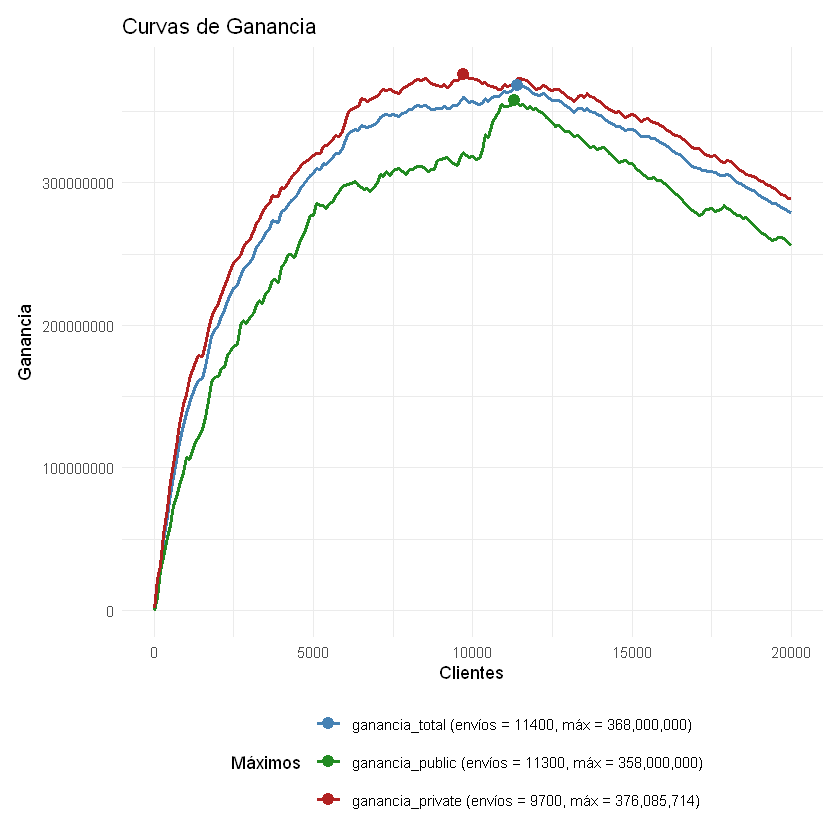

In [ ]:
# pasamos a formato largo
resultados_long <- melt(
  resultados,
  id.vars = "clientes",
  measure.vars = c("ganancia_total", "ganancia_public", "ganancia_private"),
  variable.name = "tipo",
  value.name = "ganancia"
)

# calcular máximos por tipo
maximos <- resultados_long[, .SD[which.max(ganancia)], by = tipo]

# crear etiquetas personalizadas para la leyenda
etiquetas <- paste0(
  maximos$tipo,
  " (envíos = ", maximos$clientes, ", máx = ", format(maximos$ganancia, big.mark = ","), ")"
)
names(etiquetas) <- maximos$tipo

# gráfico
ggplot(resultados_long, aes(x = clientes, y = ganancia, color = tipo)) +
  geom_line(linewidth = 1) +
  # agregar puntos en los máximos
  geom_point(data = maximos, aes(x = clientes, y = ganancia, color = tipo), size = 3) +
  labs(
    title = "Curvas de Ganancia",
    x = "Clientes",
    y = "Ganancia",
    color = "Máximos"
  ) +
  scale_color_manual(values = c("ganancia_total" = "steelblue",
                                "ganancia_public" = "forestgreen",
                                "ganancia_private" = "firebrick"),
                     labels = etiquetas) +
  theme_minimal() +
  theme(
    plot.margin = margin(10, 10, 10, 10),  # top, right, bottom, left
    legend.position = "bottom")+
  guides(color = guide_legend(nrow = 3, byrow = TRUE))
  #+ ggsave("curvas.png", width = 10, height = 6)

In [31]:
format(Sys.time(), "%a %b %d %X %Y")

[1] "sáb oct 04 19:43:44 2025"